# ABCD - The Simple Case
A very simple ABCD method calculation: Build a dataset, define a cut, and then predict A from B, C, and D. The variables created are totally uncorrelated.

We define ABCD as A in the upper left hand quadrant, B in the lower left hand, C in the upper right hand and D in the lower right hand:

       +----+----+
       |  A |  C |
    v2 +----+----+
       |  B +  D |
       +---------+
           v1
   
 Thus, the ratio is A/B = C/D or A = BC/D.
 
     A: v1 <= xcut & v2 > ycut
     B: v1 <= xcut & v2 <= ycut
     C: v1 > xcut & v2 > ycut
     D: v1 > xcut & v2 <= ycut

## Initalization

In [75]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Sample Generation

In [64]:
nSamples = 1000

In [65]:
sample_np = np.random.rand(nSamples, 2)

In [66]:
sample = pd.DataFrame(sample_np, columns=['v1', 'v2'])

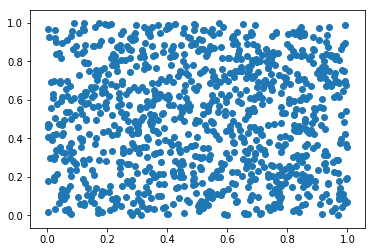

In [67]:
plt.scatter(sample['v1'], sample['v2'])

## ABCD Calculation

In [68]:
xcut = 0.5

In [69]:
ycut = 0.5

In [70]:
A = sample.loc[(sample['v1']<=xcut) & (sample['v2']>ycut)]
B = sample.loc[(sample['v1']<=xcut) & (sample['v2']<=ycut)]
C = sample.loc[(sample['v1']>xcut) & (sample['v2']>ycut)]
D = sample.loc[(sample['v1']>xcut) & (sample['v2']<=ycut)]

In [71]:
nA = len(A.index)
nB = len(B.index)
nC = len(C.index)
nD = len(D.index)

In [72]:
nB*nC/nD

243.10077519379846

In [73]:
nA

241

In [74]:
fractionalError = abs(nA - nB*nC/nD)/nA
fractionalError*100

0.8716909517835914